# Predicting Income Status

The objective of this case study is to fit and compare three different binary classifiers to predict whether an individual earns more than USD 50,000 (50K) or less in a year using the 1994 US Census Data sourced from the UCI Machine Learning Repository (Lichman, 2013). The descriptive features include 4 numeric and 7 nominal categorical features. The target feature has two classes defined as "<=50K" and ">50K" respectively. The full dataset contains about 45K observations.

This report is organized as follows:
- [Section 2 (Overview)](#2) outlines our methodology. 
- [Section 3 (Data Preparation)](#3) summarizes the data preparation process and our model evaluation strategy. 
- [Section 4 (Hyperparameter Tuning)](#4) describes the hyperparameter tuning process for each classification algorithm.
- [Section 5 (Performance Comparison)](#5) presents model performance comparison results.
- [Section 6 (Limitations)](#6) discusses a limitations of our approach and possible solutions. 
- [Section 7 (Summary)](#7) provides a brief summary of our work in this project.

Compiled from a Jupyter Notebook, this report contains both narratives and the Python code used throughout the project.

# Overview <a class="anchor" id="2"></a> 

### Methodology

We consider the following (binary) classifiers to predict the target feature:

* K-Nearest Neighbors (KNN),
* Decision trees (DT), and
* Naive Bayes (NB).

Our modeling strategy begins by transforming the full dataset cleaned in Phase I. This transformation includes encoding categorical descriptive features as numerical and then scaling of the descriptive features. We first randomly sample 20K rows from the full dataset and then split this sample into training and test sets with a 70:30 ratio. This way, our training data has 14K rows and test data has 6K rows. To be clear, our terminology here is that 
- The 14K rows of data used during the hyperparameter tuning phase is called the **training data**.
- The 6K rows of data used during the performance comparison phase is called the **test data**.

Before fitting a particular classifier on the training data, we select the best features using the powerful Random Forest Importance method inside a pipeline. We consider 10, 20, and the full set of features (with 41 features) after encoding of categorical features. Using feature selection together with hyperparameter search inside a single pipeline, we conduct a 5-fold stratified cross-validation to fine-tune hyperparameters of each classifier using area under curve (AUC) as the performance metric. We build each model using parallel processing with "-2" cores. Since the target feature has more individuals earning less than USD 50K in 1994 (unbalanced target class issue), stratification is crucial to ensure that each validation set has the same proportion of classes as in the original dataset. We also examine sensitivity of each model with respect to its hyperparameters during the search.

Classifiers with the best set of hyperparameter values as identified via grid search using the training data are called **tuned** classifiers. Once we identify the three tuned classifiers (with the best hyperparameter values), we "fit" them on the test data using 10-fold cross-validation in a paired fashion and we perform paired t-tests to see if any performance difference is statistically significant. In addition, we compare the classifiers with respect to their recall scores and confusion matrices on the test data.

# Data Preparation <a class="anchor" id="3"></a> 

## Loading Dataset

We load the dataset from the Cloud. Below we set the seed to a particular value at the beginning of this notebook so that our results can be repeated later on.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import io
import requests
import os, ssl

# set seed for reproducibility of results
np.random.seed(999)

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

dataset_url = 'https://raw.githubusercontent.com/vaksakalli/datasets/master/us_census_income_data.csv'

dataset = pd.read_csv(io.StringIO(requests.get(dataset_url).content.decode('utf-8')))

print(dataset.shape)

dataset.columns.values

(45222, 12)


array(['age', 'workclass', 'education_num', 'marital_status',
       'occupation', 'relationship', 'race', 'gender', 'hours_per_week',
       'native_country', 'capital', 'income_status'], dtype=object)

The full data has 45,222 observations. It has 11 descriptive features and the "income_status" target feature. 

## Checking for Missing Values

Let's make sure we do not have any missing values.

In [2]:
dataset.isna().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
gender            0
hours_per_week    0
native_country    0
capital           0
income_status     0
dtype: int64

Let's have a look at 5 randomly selected rows in this raw dataset.

In [3]:
dataset.sample(n=5, random_state=999)

,age,workclass,education_num,marital_status,occupation,relationship,race,gender,hours_per_week,native_country,capital,income_status
29270,40,Private,10,Never-married,Exec-managerial,Unmarried,White,Female,40,United-States,0,<=50K
25610,24,State-gov,13,Never-married,Prof-specialty,Not-in-family,White,Female,20,United-States,0,<=50K
19125,38,Self-emp-not-inc,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,40,United-States,0,>50K
43423,43,Self-emp-not-inc,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,15,United-States,0,<=50K
14464,37,Local-gov,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,60,United-States,0,>50K


## Summary Statistics

The summary statistics for the full data are shown below.

In [4]:
dataset.describe(include='all')

,age,workclass,education_num,marital_status,occupation,relationship,race,gender,hours_per_week,native_country,capital,income_status
count,45222.000000,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222,45222.000000,45222
unique,NaN,7,NaN,7,14,6,2,2,NaN,2,NaN,2
top,NaN,Private,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,United-States,NaN,<=50K
freq,NaN,33307,NaN,21055,6020,18666,38903,30527,NaN,41292,NaN,34014
mean,38.547941,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,40.938017,NaN,1012.834925,NaN
std,13.217870,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,12.007508,NaN,7530.315380,NaN
min,17.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,-4356.000000,NaN
25%,28.000000,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,0.000000,NaN
50%,37.000000,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,40.000000,NaN,0.000000,NaN
75%,47.000000,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,45.000000,NaN,0.000000,NaN


## Encoding Categorical Features

Prior to modeling, it is essential to encode all categorical features (both the target feature and the descriptive features) into a set of numerical features.

### Encoding the Target Feature
We remove the "income_status" feature from the full dataset and call it "target". The rest of the features are the descriptive features which we call "Data".

In [5]:
Data = dataset.drop(columns='income_status')
target = dataset['income_status']
target.value_counts()

<=50K    34014
>50K     11208
Name: income_status, dtype: int64

Let's encode the target feature so that the positive class is ">50K" and it is encoded as "1".

In [6]:
target = target.replace({'<=50K': 0, '>50K': 1})
target.value_counts()

0    34014
1    11208
Name: income_status, dtype: int64

As a side note, we observe that the classes are not quite balanced. 

### Encoding Categorical Descriptive Features

Since all of the descriptive features appear to be nominal, we perform one-hot-encoding. Furthermore, since we plan on conducting feature selection, we define $q$ dummy variables for a categorical descriptive variable with $q$ levels. The exception here is that when a categorical descriptive feature has only two levels, we define a single dummy variable. Let's extract the list of categorical descriptive features.

In [7]:
categorical_cols = Data.columns[Data.dtypes==object].tolist()

Before any transformation, the categorical features are as follows.

In [8]:
categorical_cols

['workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native_country']

The coding operation is shown below. For each two-level categorical variable, we set the `drop_first` option to `True` to encode the variable into a single column of 0 or 1. Next, we apply the `get_dummies()` function for the regular one-hot encoding for categorical features with more than 2 levels.

In [9]:
for col in categorical_cols:
    n = len(Data[col].unique())
    if (n == 2):
        Data[col] = pd.get_dummies(Data[col], drop_first=True)
   
# use one-hot-encoding for categorical features with >2 levels
Data = pd.get_dummies(Data)

After encoding, the feature set has the following columns.

In [10]:
Data.columns

Index(['age', 'education_num', 'race', 'gender', 'hours_per_week',
       'native_country', 'capital', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital_status_Divorced',
       'marital_status_Married-AF-spouse', 'marital_status_Married-civ-spouse',
       'marital_status_Married-spouse-absent', 'marital_status_Never-married',
       'marital_status_Separated', 'marital_status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       

In [11]:
Data.sample(5, random_state=999)

,age,education_num,race,gender,hours_per_week,native_country,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
29270,40,10,1,0,40,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
25610,24,13,1,0,20,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
19125,38,9,1,1,40,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
43423,43,9,1,0,15,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14464,37,15,1,1,60,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


## Scaling of Features

After encoding all the categorical features, we perform a min-max scaling of the descriptive features. But first we make a copy of the Data to keep track of column names.

In [12]:
from sklearn import preprocessing

Data_df = Data.copy()

Data_scaler = preprocessing.MinMaxScaler()
Data_scaler.fit(Data)
Data = Data_scaler.fit_transform(Data)

Let's have another look at the descriptive features after scaling. Pay attention that the output of the scaler is a `NumPy` array, so all the column names are lost. That's why we kept a copy of Data before scaling so that we can recover the column names below. We observe below that binary features are still kept as binary after the min-max scaling.

In [13]:
pd.DataFrame(Data, columns=Data_df.columns).sample(5, random_state=999)

,age,education_num,race,gender,hours_per_week,native_country,capital,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
29270,0.315068,0.600000,1.0,0.0,0.397959,1.0,0.041742,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25610,0.095890,0.800000,1.0,0.0,0.193878,1.0,0.041742,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19125,0.287671,0.533333,1.0,1.0,0.397959,1.0,0.041742,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
43423,0.356164,0.533333,1.0,0.0,0.142857,1.0,0.041742,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14464,0.273973,0.933333,1.0,1.0,0.602041,1.0,0.041742,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection & Ranking

Let's have a look at the most important 10 features as selected by Random Forest Importance (RFI) in the full dataset. This is for a quick ranking of the most relevant 10 features to gain some insight into the problem at hand. During the hyperparameter tuning phase, we will include RFI as part of the pipeline and we will search over 10, 20, and the full set of 41 features to determine which number of features works best with each classifier.

In [14]:
from sklearn.ensemble import RandomForestClassifier

num_features = 10
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['age', 'capital', 'education_num', 'hours_per_week',
       'marital_status_Married-civ-spouse', 'relationship_Husband',
       'marital_status_Never-married', 'occupation_Exec-managerial',
       'occupation_Prof-specialty', 'gender'], dtype=object)

In [15]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.23428436, 0.15212082, 0.13338332, 0.11455362, 0.09567756,
       0.04344617, 0.02271989, 0.01861711, 0.01709752, 0.01448403])

Let's visualize these importances.

In [16]:
%config InlineBackend.figure_format = 'retina'

import altair as alt
alt.renderers.enable('notebook') # required in Jupyter notebooks

def plot_imp(best_features, scores, method_name, color):
    
    df = pd.DataFrame({'features': best_features, 
                       'importances': scores})
    
    chart = alt.Chart(df, 
                      width=500, 
                      title=method_name + ' Feature Importances'
                     ).mark_bar(opacity=0.85, 
                                color=color).encode(
        alt.X('features', title='Feature', sort=None, axis=alt.AxisConfig(labelAngle=45)),
        alt.Y('importances', title='Importance')
    )
    
    return chart

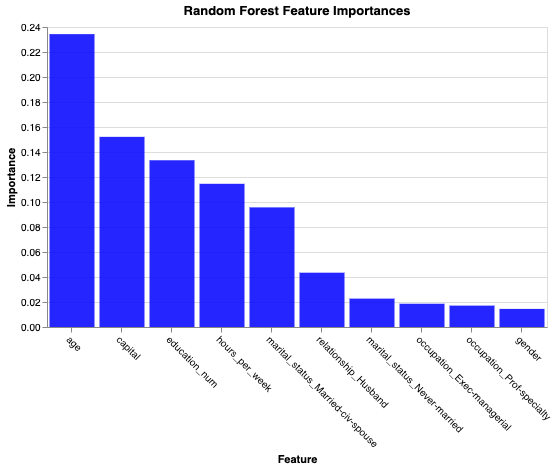

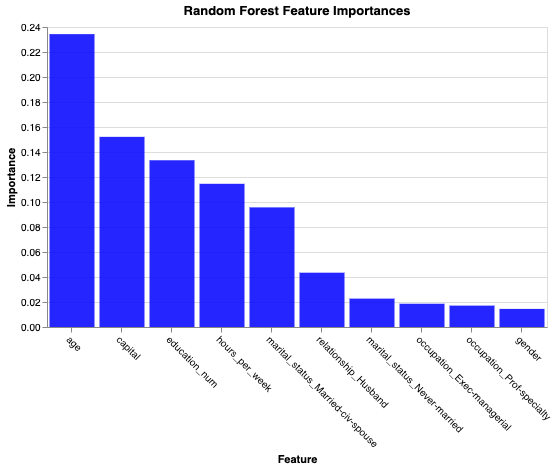

In [17]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest', 'blue')

We observe that the most important feature is age, followed by capital, education, and hours per week.

## Data Sampling & Train-Test Splitting

The original dataset has more than 45K rows, which is a lot. So, we would like to work with a small sample here with 20K rows. Thus, we will do the following:
- Randomly select 20K rows from the full dataset.
- Split this sample into train and test partitions with a 70:30 ratio using stratification.

Pay attention here that we use `values` attribute to convert `Pandas` data frames to a `NumPy` array. You have to make absolutely sure that you **NEVER** pass `Pandas` data frames to `Scikit-Learn` functions!!! Sometimes it will work. But sometimes you will end up getting strange errors such as "invalid key" etc. Remember, `Scikit-Learn` works with `NumPy` arrays, not `Pandas` data frames.

In [18]:
n_samples = 20000

Data_sample = pd.DataFrame(Data).sample(n=n_samples, random_state=8).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=8).values

print(Data_sample.shape)
print(target_sample.shape)

(20000, 41)
(20000, 1)


In [19]:
from sklearn.model_selection import train_test_split

Data_sample_train, Data_sample_test, \
target_sample_train, target_sample_test = train_test_split(Data_sample, target_sample, 
                                                    test_size = 0.3, random_state=999,
                                                    stratify = target_sample)

print(Data_sample_train.shape)
print(Data_sample_test.shape)

(14000, 41)
(6000, 41)


## Model Evaluation Strategy

So, we will train and tune our models on 14K rows of training data and we will test them on 6K rows of test data. 

For each model, we will use 5-fold stratified cross-validation evaluation method (without any repetitions for shorter run times) for hyperparameter tuning.

In [20]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv_method = StratifiedKFold(n_splits=5, random_state=999)

# Hyperparameter Tuning <a class="anchor" id="4"></a> 

## K-Nearest Neighbors (KNN)

Using `Pipeline`, we stack feature selection and grid search for KNN hyperparameter tuning via cross-validation. We will use the same `Pipeline` methodology for NB and DT.

The KNN hyperparameters are as follows:

* number of neighbors (`n_neighbors`) and
* the distance metric `p`.

For feature selection, we use the powerful Random Forest Importance (RFI) method with 100 estimators. A trick here is that we need a bit of coding so that we can make RFI feature selection as part of the pipeline. For this reason, we define the custom `RFIFeatureSelector()` class
below to pass in RFI as a "step" to the pipeline.

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    # make sure class attributes end with a "_"
    # per scikit-learn convention to avoid errors
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                   'knn__n_neighbors': [1, 5, 10, 15, 20],
                   'knn__p': [1, 2]}

gs_pipe_KNN = GridSearchCV(estimator=pipe_KNN, 
                           param_grid=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                           scoring='roc_auc',
                           verbose=1) 

In [23]:
gs_pipe_KNN.fit(Data_sample_train, target_sample_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:  1.4min finished


In [24]:
gs_pipe_KNN.best_params_

{'knn__n_neighbors': 20, 'knn__p': 1, 'rfi_fs__n_features_': 10}

In [25]:
gs_pipe_KNN.best_score_

0.8712215059926984

We observe that the optimal KNN model has a mean AUC score of 0.871. The best performing KNN selected 10 features with 20 nearest neighbors and $p=1$, which is the Manhattan distance.

Even though these are the best values, let's have a look at the other combinations to see if the difference is rather significant or not. For this, we will make use of the function below to format the grid search outputs as a `Pandas` data frame.

In [26]:
# custom function to format the search results as a Pandas data frame
def get_search_results(gs):

    def model_result(scores, params):
        scores = {'mean_score': np.mean(scores),
             'std_score': np.std(scores),
             'min_score': np.min(scores),
             'max_score': np.max(scores)}
        return pd.Series({**params,**scores})

    models = []
    scores = []

    for i in range(gs.n_splits_):
        key = f"split{i}_test_score"
        r = gs.cv_results_[key]        
        scores.append(r.reshape(-1,1))

    all_scores = np.hstack(scores)
    for p, s in zip(gs.cv_results_['params'], all_scores):
        models.append((model_result(s, p)))

    pipe_results = pd.concat(models, axis=1).T.sort_values(['mean_score'], ascending=False)

    columns_first = ['mean_score', 'std_score', 'max_score', 'min_score']
    columns = columns_first + [c for c in pipe_results.columns if c not in columns_first]

    return pipe_results[columns]

In [27]:
results_KNN = get_search_results(gs_pipe_KNN)
results_KNN.head()

,mean_score,std_score,max_score,min_score,knn__n_neighbors,knn__p,rfi_fs__n_features_
24,0.871222,0.002937,0.876753,0.868195,20.0,1.0,10.0
27,0.870801,0.003831,0.877900,0.867527,20.0,2.0,10.0
25,0.870415,0.007403,0.880122,0.860804,20.0,1.0,20.0
28,0.870080,0.006595,0.879731,0.862198,20.0,2.0,20.0
26,0.869560,0.005066,0.877130,0.862122,20.0,1.0,41.0


We observe that the difference between the hyperparameter combinations is not really much when conditioned on the number of features selected. Let's visualize the results of the grid search corresponding to 10 selected features.

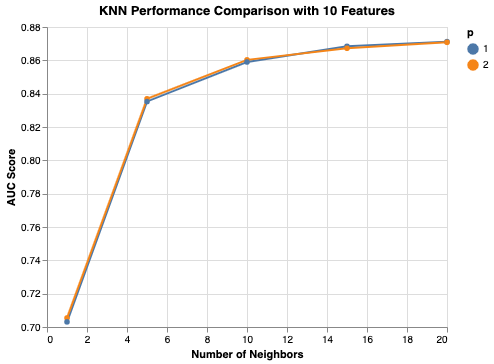

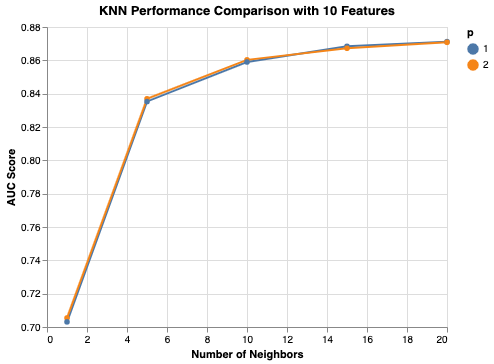

In [28]:
import altair as alt

results_KNN_10_features = results_KNN[results_KNN['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_KNN_10_features, 
          title='KNN Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('knn__n_neighbors', title='Number of Neighbors'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('knn__p:N', title='p')
)

## (Gaussian) Naive Bayes (NB)

We implement a Gaussian Naive Bayes model.  We optimize `var_smoothing` (a variant of Laplace smoothing) as we do not have any prior information about our dataset. By default, the `var_smoothing` parameter's value is $10^{-9}$ . We conduct the grid search in the `logspace` (over the powers of 10) sourced from `NumPy`. We start with 10 and end with $10^{-3}$ with 200 different values, but we perform a random search over only 20 different values (for shorter run times). Since NB requires each descriptive feature to follow a Gaussian distribution, we first perform a power transformation on the input data before model fitting.

In [29]:
from sklearn.preprocessing import PowerTransformer
Data_sample_train_transformed = PowerTransformer().fit_transform(Data_sample_train)

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'nb__var_smoothing': np.logspace(1,-3, num=200)}

n_iter_search = 20
gs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          n_iter=n_iter_search,
                          verbose=1) 

gs_pipe_NB.fit(Data_sample_train_transformed, target_sample_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed:   36.3s finished


In [31]:
gs_pipe_NB.best_params_

{'rfi_fs__n_features_': 10, 'nb__var_smoothing': 0.5170920242896758}

In [32]:
gs_pipe_NB.best_score_

0.8788575689517928

The optimal NB yiels an AUC score of 0.878 (with 10 features) - slightly higher than that of KNN. At this point, we cannot conclude NB outperforms KNN. For this conclusion, we will have to perform a paired t-test on the test data as discussed further below.

In [33]:
results_NB = get_search_results(gs_pipe_NB)
results_NB.head()

,mean_score,std_score,max_score,min_score,rfi_fs__n_features_,nb__var_smoothing
2,0.878858,0.006011,0.885646,0.869283,10.0,0.517092
10,0.874880,0.006124,0.882757,0.866758,10.0,4.150405
13,0.874546,0.005880,0.880257,0.864868,10.0,0.040555
9,0.873888,0.006338,0.882258,0.864246,10.0,0.004009
14,0.873790,0.005858,0.879619,0.864290,10.0,0.007317


Let's visualize the search results.

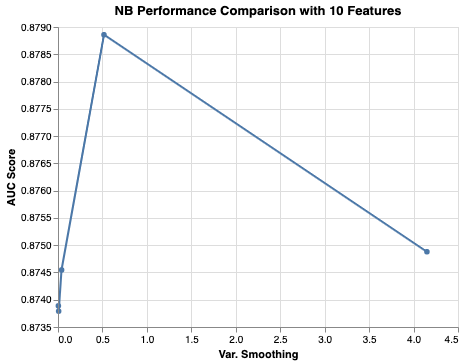

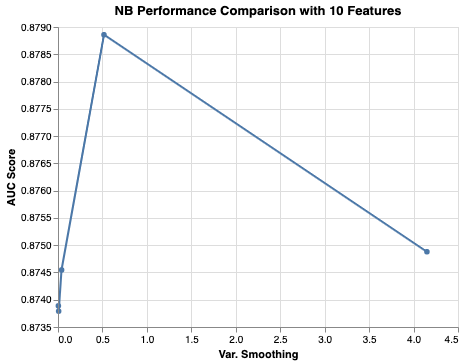

In [34]:
results_NB_10_features = results_NB[results_NB['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_NB_10_features, 
          title='NB Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('nb__var_smoothing', title='Var. Smoothing'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False))
)

## Decision Trees (DT)

We build a DT using gini index to maximize information gain. We aim to determine the optimal combinations of maximum depth (`max_depth`) and minimum sample split (`min_samples_split`).

In [35]:
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='gini', random_state=111))])

params_pipe_DT = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'dt__max_depth': [3, 4, 5],
                  'dt__min_samples_split': [2, 5]}

gs_pipe_DT = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT.fit(Data_sample_train, target_sample_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:   36.0s finished


In [36]:
gs_pipe_DT.best_params_

{'dt__max_depth': 5, 'dt__min_samples_split': 2, 'rfi_fs__n_features_': 41}

In [37]:
gs_pipe_DT.best_score_

0.8810336380172188

The best DT has a maximum depth of 5 and minimum split value of 2 samples with an AUC score of 0.881. A visualization of the search results is given below for 10 features.

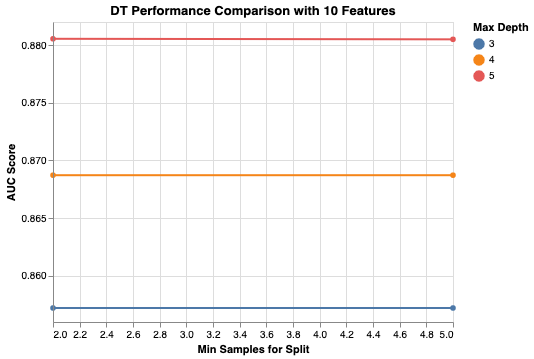

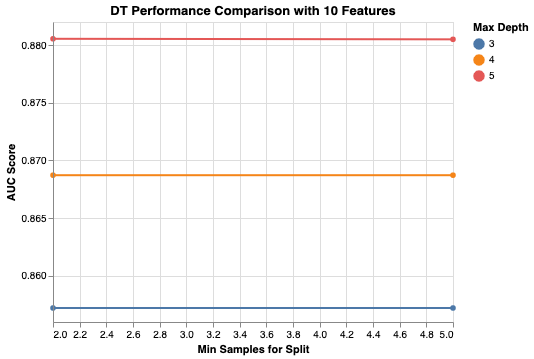

In [38]:
results_DT = get_search_results(gs_pipe_DT)

results_DT_10_features = results_DT[results_DT['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_DT_10_features, 
          title='DT Performance Comparison with 10 Features'
         ).mark_line(point=True).encode(
    alt.X('dt__min_samples_split', title='Min Samples for Split'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('dt__max_depth:N', title='Max Depth')
)

## Further Fine Tuning

We notice that the optimal value of maximum depth hyperparameter is at the extreme end of its search space. Thus, we need to go beyond what we already tried to make sure that we are not missing out on even better values. For this reason, we try a new search as below.    

In [39]:
params_pipe_DT2 = {'rfi_fs__n_features_': [10],
                  'dt__max_depth': [5, 10, 15],
                  'dt__min_samples_split': [5, 50, 100, 150]}

gs_pipe_DT2 = GridSearchCV(estimator=pipe_DT, 
                          param_grid=params_pipe_DT2, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          verbose=1) 

gs_pipe_DT2.fit(Data_sample_train, target_sample_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed:   22.1s finished


In [40]:
gs_pipe_DT2.best_params_

{'dt__max_depth': 10, 'dt__min_samples_split': 100, 'rfi_fs__n_features_': 10}

In [41]:
gs_pipe_DT2.best_score_

0.8940001158415596

As suspected, we can achieve slightly better results with the new search space.

In [42]:
results_DT = get_search_results(gs_pipe_DT2)
results_DT.head()

,mean_score,std_score,max_score,min_score,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_
6,0.894000,0.003514,0.899743,0.890165,10.0,100.0,10.0
11,0.893843,0.004216,0.898181,0.886410,15.0,150.0,10.0
10,0.893525,0.003808,0.899991,0.889082,15.0,100.0,10.0
7,0.892765,0.003247,0.897515,0.888206,10.0,150.0,10.0
5,0.892439,0.003295,0.897922,0.887530,10.0,50.0,10.0


We again observe that the cross-validated AUC score difference between the hyperparameter combinations is not really much. A visualization of the new search results is shown below.

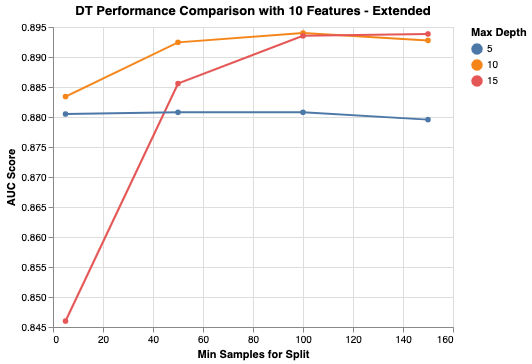

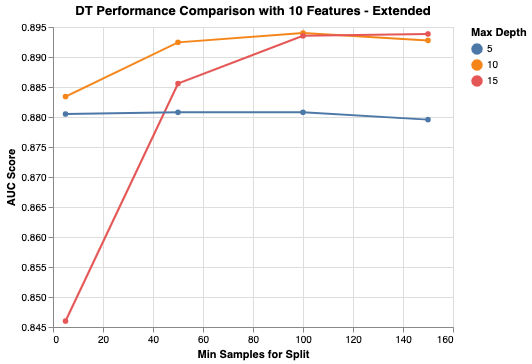

In [43]:
results_DT_10_features = results_DT[results_DT['rfi_fs__n_features_'] == 10.0]

alt.Chart(results_DT_10_features, 
          title='DT Performance Comparison with 10 Features - Extended'
         ).mark_line(point=True).encode(
    alt.X('dt__min_samples_split', title='Min Samples for Split'),
    alt.Y('mean_score', title='AUC Score', scale=alt.Scale(zero=False)),
    alt.Color('dt__max_depth:N', title='Max Depth')
)

# Performance Comparison <a class="anchor" id="5"></a> 

During the hyperparameter tuning phase above, we used the 14K rows in our **training data** within a cross-validation framework and we determined the best hyperparameter values for each of the three classifiers. For instance, for KNN, it turned out that the best set of hyperparameter values is $k=100$ and $p=1$ with the best 10 features as selected by the RFI feature selection method.

What we would like to do now is to **"fit"** each tuned classifier (with the best set of hyperparameter values) on the 6K rows in the **test data** in a cross-validated fashion to figure out which (tuned) classifier performs the best. This way, we would be measuring performance of the tuned classifiers on data that they did not **"see"** previously. 

Since cross validation itself is a random process, we would like to perform pairwise t-tests to determine if any difference between the performance of any two (tuned) classifiers is statistically significant [1]. Specifically, we first perform 10-fold stratified cross-validation (without any repetitions) on each (tuned) classifier where we use the **same** seed in each of the three cross-validation runs. Second, we conduct a paired t-test for the AUC score between the following (tuned) classifier combinations:

* KNN vs. NB,
* KNN vs. DT, and
* DT vs. NB.

## Discussion

**Machine learning is as much as art as it is science.** A proper performance comparison can be conducted in other ways (including the particular variant in here). On the other hand, what is "proper" depends on your objectives as well as the characteristics of the dataset you are working with. 

For instance, in the case where amount of data available is especially a concern (say less than a few hundred observations), you might want to use 100% of the dataset as the **training data** during the hyperparameter tuning phase, and also use 100% of the dataset as the **test data** during the performance comparison phase (this time using a different random seed). Here, you might want to opt for, say, 5-repeated 3-fold cross-validation. Apparently, this will be rather inappropriate as you would be using the same data in both of the tuning and performance comparison phases. However, since both phases involve cross-validation, effects of overfitting shall be quite limited. In particular, you might just decide that this is an acceptable trade-off given the lack of enough observations to work with.

Another popular performance comparison method calls for two **nested** cross-validation runs as follows: you resort to a train-test-split approach within an outer cross-validation framework, say 3-repeated 5-fold cross-validation, and you perform hyperparameter tuning using a possibly different inner cross-validation scheme (say 5-fold with no repetitions). This variant is rather involved and we do not cover it in this tutorial.

[1]: For more than two classifiers, it is more appropriate to use Tukey's post-hoc tests or its non-parametric counterpart. However, these statistical inference techniques are beyond our scope.

In [44]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = StratifiedKFold(n_splits=10, random_state=111)

cv_results_KNN = cross_val_score(estimator=gs_pipe_KNN.best_estimator_,
                                 X=Data_sample_test,
                                 y=target_sample_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.8701375792477201

In [45]:
Data_sample_test_transformed = PowerTransformer().fit_transform(Data_sample_test)

cv_results_NB = cross_val_score(estimator=gs_pipe_NB.best_estimator_,
                                X=Data_sample_test_transformed,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_NB.mean()

0.8802864333996482

In [46]:
cv_results_DT = cross_val_score(estimator=gs_pipe_DT2.best_estimator_,
                                X=Data_sample_test,
                                y=target_sample_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_DT.mean()

0.8916145587002611

Since we fixed the random state to be same during cross-validation, all (tuned) classifiers were fitted and then tested on exactly the same data partitions, making our results "paired" in a statistical sense. So, we use the `stats.ttest_rel` function from the `SciPy` module to run the following (paired) t-tests.

In [47]:
from scipy import stats

print(stats.ttest_rel(cv_results_KNN, cv_results_NB))
print(stats.ttest_rel(cv_results_DT, cv_results_KNN))
print(stats.ttest_rel(cv_results_DT, cv_results_NB))

Ttest_relResult(statistic=-2.2591810843684894, pvalue=0.05024379615887901)
Ttest_relResult(statistic=4.10925618709444, pvalue=0.0026399425515145672)
Ttest_relResult(statistic=3.162293010033419, pvalue=0.011507701083529628)


A p-value smaller than 0.05 indicates a statistically significant difference. Looking at these results, we conclude that at a 95% significance level, DT is statistically the best model in this competition (in terms of AUC) when compared on the **test data**.

Though we used AUC to optimize the algorithm hyperparameters, we shall consider the following metrics to evaluate models based on the test set:

* Accuracy
* Precision
* Recall
* F1 Score (the harmonic average of precision and recall)
* Confusion Matrix

These metrics can be computed using `classification_report` from `sklearn.metrics`. The classification reports are shown below.

In [48]:
pred_KNN = gs_pipe_KNN.predict(Data_sample_test)

In [49]:
Data_test_transformed = PowerTransformer().fit_transform(Data_sample_test)
pred_NB = gs_pipe_NB.predict(Data_test_transformed)

In [50]:
pred_DT = gs_pipe_DT2.predict(Data_sample_test)

In [51]:
from sklearn import metrics
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(target_sample_test, pred_KNN))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(target_sample_test, pred_NB))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(target_sample_test, pred_DT))


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4471
           1       0.72      0.53      0.61      1529

    accuracy                           0.83      6000
   macro avg       0.79      0.73      0.75      6000
weighted avg       0.82      0.83      0.82      6000


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4471
           1       0.65      0.70      0.67      1529

    accuracy                           0.82      6000
   macro avg       0.77      0.78      0.78      6000
weighted avg       0.83      0.82      0.83      6000


Classification report for Decision Tree
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4471
           1       0.77      0.57      0.66      1529

    accuracy                           0.85      6000
  

The confusion matrices are given below.

In [52]:
from sklearn import metrics
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(target_sample_test, pred_KNN))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(target_sample_test, pred_NB))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(target_sample_test, pred_DT))


Confusion matrix for K-Nearest Neighbor
[[4160  311]
 [ 723  806]]

Confusion matrix for Naive Bayes
[[3886  585]
 [ 465 1064]]

Confusion matrix for Decision Tree
[[4218  253]
 [ 659  870]]


Suppose we are a tax agency and we would like to detect individuals earning more than USD 50K. Then we would choose recall as the performance metric, which is equivalent to the true positive rate (TPR). In this context, NB would be the best performer since it produces the highest recall score for incomes higher than USD 50K. The confusion matrices are in line with the classification reports. This is in contrast to our finding that DT is statistically the best performer when it comes to the AUC metric.

# Limitations and Proposed Solutions <a class="anchor" id="6"></a> 

Our modeling strategy has a few flaws and limitations. First, ours was a black-box approach since we preferred raw predictive performance over interpretability. In the future, we could consider a more in-depth analysis about the feature selection & ranking process as well as our choices for the hyperparameter spaces.

Second, we utilized a blanket power transformation on the training data when building the NB, ignoring the dummy features within the dataset. This might partially explain the poor performance of the NB when evaluated on the test set. A potential solution is to build a Gaussian NB and a Bernoulli NB separately on the numerical and dummy descriptive features respectively. Then we can compute a final prediction by multiplying predictions from each model since NB assumes inter-independence conditioned on the value of the target feature.

Third, we only worked with a small subset of the full dataset for shorter run times, both for training and testing. Since data is always valuable, we could re-run our experiments with the entire data while making sure that the train and test split is performed in a proper manner.

The DT classifier statistically outperforms the other two models. Therefore, we can perhaps improve it by further expanding the hyperparameter search space by including other parameters of this classification method. Furthermore, we can consider random forests and other ensemble methods built on trees as potentially better models.

# Summary <a class="anchor" id="7"></a> 

The Decision Tree model with 10 of the best features selected by Random Forest Importance (RFI) produces the highest cross-validated AUC score on the training data. In addition, when evaluated on the test data (in a cross-validated fashion), the Decision Tree model again outperforms both Naive Bayes and k-Nearest Neighbor models with respect to AUC. However, the Naive Bayes model yields the highest recall score on the test data. We also observe that our models are not very sensitive to the number of features as selected by RFI when conditioned on the values of the hyperparameters in general. For this reason, it seems working with 10 features is preferable to working with the full feature set, which potentially avoids overfitting and results in models that are easier to train and easier to understand.

# References

* Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Accessed 2019-05-26].
* Lichman, M. (2013). UCI Machine Learning Repository: Census Income Data Set [online]. Available at
https://archive.ics.uci.edu/ml/datasets/adult [Accessed 2019-05-26]
* Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-
2830.
* Travis E, Oliphant (2006). A guide to NumPy, USA: Trelgol Publishing.

***
www.featureranking.com